In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
sys.path.append('../python/')

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

#other computational libraries
import numpy as np
import pandas as pd
import scipy
import scipy.constants as co
import scipy.stats as ss
from scipy.ndimage import shift
import itertools
import pickle

In [2]:
import pickle
#how to read
#fileObj = open('data/r76-80V-naitrig-100eV-goodchi.pkl', 'rb')
fileObj = open('data/r76_events_coincidencepeak.pkl', 'rb')
exampleObj = pickle.load(fileObj)
fileObj.close()
#print(exampleObj)

In [3]:
import statistics as st
def isRailed(v):
    if(np.isnan(v).any()):
        return True
    if(st.mode(v)==0):
        return True
    return False

In [4]:
#import singularity_pulseSave as sps
import pulseAnalysis as pa

pulse_struct = pa.parseEventList('../coin_analysis/data/r76-coinpeak-gt-50keV.txt')

#pulse_struct = sps.parseEventList('../coin_analysis/data/r76_events_coincidencepeak.txt')

   SeriesNumber  EventNumber
0   72209162200        30273
1   72209162200        70006
2   72209162200        80047
3   72209162200       100850
4   72209162200       110307
5   72209162200       130025
6   72209162200       150876
7   72209162200       160028
8   72209162200       170463
9   72209162200       180787
[72209162200 72209171225 72209172155]
[  30273   70006   80047  100850  110307  130025  150876  160028  170463
  180787  190079  220095  230127  230377  230775  250878  270133  280450
  290139  290301  300773  330520  330924  340147  340705  370726  380017
  410662  430050  430054  440388  450132  460753  460821  470097  480651
  490274  510691  540114  540466  550020  550628  580010  580133  580227
  610367  610447  620766  630735  670014  670095  670140  680194  680395
  680651  680857  690650  690744  700105  720006  720467  770005  780005
  780122  780170  780377  780430  790907  800793  820330  830348  850764
  870886  880263  890099  890305  890719  900814  910136  9

In [5]:
coindata = pd.read_csv("../coin_analysis/data/r76_events_coincidencepeak.txt", skiprows=3, engine='python',skipfooter=1,sep="*",skipinitialspace=True, \
            index_col=False, \
            names=['garbage','Row','SeriesNumber','EventNumber','PTOFdelay','pt_keVee'], \
            delim_whitespace=False)

series_nums = np.asarray(coindata['SeriesNumber'])
event_nums = np.asarray(coindata['EventNumber'])
EkeV = np.asarray(coindata['pt_keVee'])
PTOFdelay = np.asarray(coindata['PTOFdelay'])

def getEnergy(series,ev):
    energy = 0

    for i in range(0, len(series_nums)):
        if series_nums[i] == series:
            if event_nums[i] == ev:
                energy = (EkeV[i])
    return energy

def getBaseline(ptpulse):
    
    x = np.linspace(100, 250, 150)
    #print(len(x))
    y = ptpulse[100:250]
    #print(len(y))
    
    #print(x)
    #print(y)
    
    baseline_model = np.polyfit(x, y, 1)
    baseline_model_fn = np.poly1d(baseline_model)
    
    return(baseline_model_fn)

In [6]:
# toggle plotting each pulse
plot = False

### Basic Discriminator

In [7]:
def getPTPulse(pulses,series=72209162200,ev=30273,chan=[('Z1','PA'),('Z1','PB'),('Z1','PD'),('Z3','PA'),('Z3','PB'),('Z3','PD')]):
    ptpulse=[]
    ccount=0
    zerocross=0
    for c in chan:
        #print(c[0])
        pulse = pulses[c[0]][c[1]][series,ev]
        if(isRailed(pulse)):
            continue
        mean = np.mean(pulse[100:])
        pulse = pulse-mean
        
        #adding discriminator
        end_values = pulse[3997:]
        #print(end_values)
        new_pulse = shift(pulse,100,cval=np.nan)
        #print(new_pulse)
        
        #adding the cut off values to the front of the new pulse
        new_pulse[0:99] = end_values
        #print(new_pulse)
        
        if(ccount==0):
            ptpulse=new_pulse
        else:
            ptpulse+=new_pulse
        ccount+=1

    #print(ptpulse)
    return ptpulse

In [8]:
getPTPulse(exampleObj)

array([-1133.51926927, -1133.51926927, -1132.51926927, ...,
       -1136.51926927, -1133.51926927, -1136.51926927])

In [9]:
loops = 0
time_reg = []
energies = []

for s in pulse_struct:
    ser=int(s.replace('_',''))
    for ev in pulse_struct[s]:
        
        #print(exampleObj['Z1']['PA'][ser,ev])
        energy = getEnergy(ser, ev)
        
        shownpulses=0
        
        #if energy > 51:
        #    continue

        #plt.subplot(8,12)
        if(not isRailed(exampleObj['Z1']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PA'][ser,ev],label="pC") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z1']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PB'][ser,ev],label="pF")
        if(not isRailed(exampleObj['Z1']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PD'][ser,ev],label="pE")
        if(not isRailed(exampleObj['Z3']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PA'][ser,ev],label="pB") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z3']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PB'][ser,ev],label="pA")
        if(not isRailed(exampleObj['Z3']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PD'][ser,ev],label="pD")
            
        pT = getPTPulse(exampleObj,ser,ev)+3000
        baseline = getBaseline(pT)
        xB = np.linspace(0, 4095, 4096)
        yB = baseline(xB)
        
        bshifted_pT = np.subtract(pT,yB)

        if(shownpulses>0):
                        
            crosses = np.isclose(bshifted_pT, 250, atol=30.0)
            
            #t = 0
            for i in range(0,750):
                if (crosses[i] == True):
                    time_reg.append(i)
                    print("Crosses at bin: " + str(i))
                    energies.append(energy)
                    #t += 1
                    break
                    
            if (plot==True):
                
                print("Series Number: " + str(ser))
                print("Event Number: " + str(ev))
                print("Energy: " + str(energy) + " keV")
        
                fig,axes = plt.subplots(1,1,figsize=(10.0,8.0),sharex=True)
                ax1 = axes
                
                ax1.plot(bshifted_pT, label="pT")
                #ax1.plot(xB, yB, color='r', linestyle="--", label="baseline")
                plt.axhline(y=250, color='r', linestyle="--")
                
                #ax1.plot((exampleObj['Z4']['PA'][ser,ev]/3)+2900-2650)
                #plt.title('PA')
                ax1.legend(loc=1,prop={'size':22})
                ax1.set_xlim(0,4096)
                ax1.set_xlabel('Bin')
                ax1.set_ylabel('Trace amplitude')
                plt.axvline(x=500,color='k',linestyle="--")

                if shownpulses > 0:
                    #plt.savefig(f'figures/{energy}_keV_pulse.png')
                    plt.show()
                    
            #if t == 0:
            #    time_reg.append(0)
            
            loops += 1
            
#print(time_reg)
#print(loops, len(time_reg))

#print(energies)

delay = np.asarray(time_reg)-500
print(delay)

Crosses at bin: 607
Crosses at bin: 616
Crosses at bin: 298
Crosses at bin: 0
Crosses at bin: 0
Crosses at bin: 599
Crosses at bin: 586
Crosses at bin: 514
Crosses at bin: 663
Crosses at bin: 609
Crosses at bin: 664
Crosses at bin: 546
Crosses at bin: 608
Crosses at bin: 602
Crosses at bin: 607
Crosses at bin: 100
Crosses at bin: 529
Crosses at bin: 48
Crosses at bin: 552
Crosses at bin: 594
Crosses at bin: 557
Crosses at bin: 528
Crosses at bin: 611
Crosses at bin: 559
Crosses at bin: 548
Crosses at bin: 95
Crosses at bin: 551
Crosses at bin: 100
Crosses at bin: 621
Crosses at bin: 614
Crosses at bin: 67
Crosses at bin: 343
Crosses at bin: 610
Crosses at bin: 617
Crosses at bin: 635
Crosses at bin: 661
Crosses at bin: 627
Crosses at bin: 605
Crosses at bin: 593
Crosses at bin: 635
Crosses at bin: 559
Crosses at bin: 544
Crosses at bin: 0
Crosses at bin: 615
Crosses at bin: 569
Crosses at bin: 3
Crosses at bin: 518
Crosses at bin: 519
Crosses at bin: 100
Crosses at bin: 0
Crosses at bi

Crosses at bin: 100
Crosses at bin: 527
Crosses at bin: 613
Crosses at bin: 523
Crosses at bin: 624
Crosses at bin: 526
Crosses at bin: 514
Crosses at bin: 363
Crosses at bin: 617
Crosses at bin: 653
Crosses at bin: 622
Crosses at bin: 602
Crosses at bin: 595
Crosses at bin: 551
Crosses at bin: 498
Crosses at bin: 601
Crosses at bin: 517
Crosses at bin: 606
Crosses at bin: 608
Crosses at bin: 598
Crosses at bin: 603
Crosses at bin: 0
Crosses at bin: 3
Crosses at bin: 535
Crosses at bin: 4
Crosses at bin: 0
Crosses at bin: 84
Crosses at bin: 577
Crosses at bin: 59
Crosses at bin: 612
Crosses at bin: 519
Crosses at bin: 571
Crosses at bin: 0
Crosses at bin: 515
Crosses at bin: 430
Crosses at bin: 609
Crosses at bin: 604
Crosses at bin: 528
Crosses at bin: 579
Crosses at bin: 624
Crosses at bin: 322
Crosses at bin: 605
Crosses at bin: 518
Crosses at bin: 606
Crosses at bin: 522
Crosses at bin: 487
Crosses at bin: 564
Crosses at bin: 623
Crosses at bin: 0
Crosses at bin: 546
Crosses at bin

Crosses at bin: 0
Crosses at bin: 3
Crosses at bin: 587
Crosses at bin: 0
Crosses at bin: 100
Crosses at bin: 614
Crosses at bin: 0
Crosses at bin: 536
Crosses at bin: 5
Crosses at bin: 654
Crosses at bin: 608
Crosses at bin: 100
Crosses at bin: 615
Crosses at bin: 32
Crosses at bin: 610
Crosses at bin: 499
Crosses at bin: 565
Crosses at bin: 612
Crosses at bin: 653
Crosses at bin: 100
Crosses at bin: 632
Crosses at bin: 1
Crosses at bin: 652
Crosses at bin: 0
Crosses at bin: 527
Crosses at bin: 100
Crosses at bin: 634
Crosses at bin: 615
Crosses at bin: 643
Crosses at bin: 613
Crosses at bin: 563
Crosses at bin: 615
Crosses at bin: 596
Crosses at bin: 100
Crosses at bin: 614
Crosses at bin: 541
Crosses at bin: 661
Crosses at bin: 667
Crosses at bin: 618
Crosses at bin: 615
Crosses at bin: 15
Crosses at bin: 627
Crosses at bin: 539
Crosses at bin: 535
Crosses at bin: 660
Crosses at bin: 50
Crosses at bin: 410
Crosses at bin: 643
Crosses at bin: 4
Crosses at bin: 607
Crosses at bin: 465

In [10]:
print(loops, len(time_reg))

1167 1125


(0.0, 200.0)

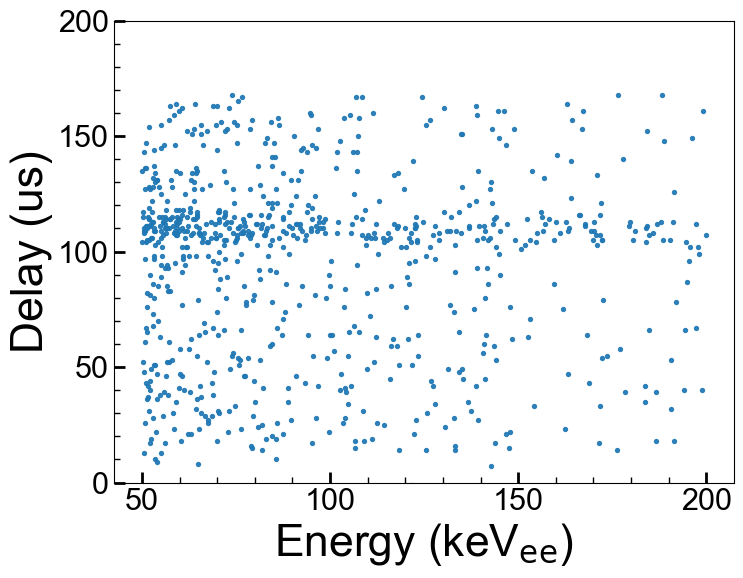

In [11]:
fig, axs = plt.subplots(1,1,figsize=(8,6))
ax1 = axs

ax1.scatter(energies, delay, marker='o', alpha=0.9, s=8)

ax1.set(xlabel="Energy (keV$_{\mathrm{ee}}$)", ylabel="Delay (us)")
    
#plt.xlim(0, 200)
plt.ylim(0,200)

### Constant Fraction Discriminator

In [12]:
def getPTPulseCFD(pulses,series=72209162200,ev=30273,chan=[('Z1','PA'),('Z1','PB'),('Z1','PD'),('Z3','PA'),('Z3','PB'),('Z3','PD')]):
    ptpulse=[]
    ccount=0
    for c in chan:
        #print(c[0])
        pulse = pulses[c[0]][c[1]][series,ev]
        if(isRailed(pulse)):
            continue
        mean = np.mean(pulse[100:])
        pulse = pulse-mean
        
        #CFD formula
        F = 0.1
        D = 100
        CFD = F*(pulse)-(pulse-D)

        end_values = pulse[3997:]
        #print(end_values)
        new_pulse = shift(pulse,100,cval=np.nan)
        #print(new_pulse)
        
        #adding the cut off values to the front of the new pulse
        new_pulse[0:99] = end_values
        #print(new_pulse)
        
        CFD_pulse = F*(new_pulse)-new_pulse
        
        if(ccount==0):
            ptpulse=CFD_pulse
        else:
            ptpulse+=CFD_pulse
        ccount+=1

    #print(ptpulse)
    return ptpulse

In [13]:
getPTPulseCFD(exampleObj)

array([1020.16734234, 1020.16734234, 1019.26734234, ..., 1022.86734234,
       1020.16734234, 1022.86734234])

In [14]:
loops = 0
time_cfd = []
energies = []

for s in pulse_struct:
    ser=int(s.replace('_',''))
    for ev in pulse_struct[s]:

        #print(exampleObj['Z1']['PA'][ser,ev])
        energy = getEnergy(ser, ev)
        
        shownpulses=0
        
        #if energy > 50.5:
        #    continue
    
        shownpulses=0

        if(not isRailed(exampleObj['Z1']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PA'][ser,ev],label="pC") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z1']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PB'][ser,ev],label="pF")
        if(not isRailed(exampleObj['Z1']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PD'][ser,ev],label="pE")
        if(not isRailed(exampleObj['Z3']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PA'][ser,ev],label="pB") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z3']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PB'][ser,ev],label="pA")
        if(not isRailed(exampleObj['Z3']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PD'][ser,ev],label="pD")
            
        pT = getPTPulseCFD(exampleObj,ser,ev)+3000
        baseline = getBaseline(pT)
        xB = np.linspace(0, 4095, 4096)
        yB = baseline(xB)
        
        bshifted_pT = np.subtract(pT,yB)

        if(shownpulses>0):
                        
            crosses = np.isclose(bshifted_pT, -100, atol=30.0)
            
            #t = 0
            for i in range(0,750):
                if (crosses[i] == True):
                    time_cfd.append(i)
                    print("Crosses at bin: " + str(i))
                    energies.append(energy)
                    #t += 1
                    break
                    
                    
            if (plot==True):
                
                print("Series Number: " + str(ser))
                print("Event Number: " + str(ev))
                print("Energy: " + str(energy) + " keV")
        
                fig,axes = plt.subplots(1,1,figsize=(10.0,8.0),sharex=True)
                ax1 = axes
                
                ax1.plot(np.subtract(pT, yB), label="pT")
                #ax1.plot(xB, yB, color='r', linestyle="--", label="baseline")
                plt.axhline(y=-100, color='r', linestyle="--")
                
                #ax1.plot((exampleObj['Z4']['PA'][ser,ev]/3)+2900-2650)
                #plt.title('PA')
                ax1.legend(loc=1,prop={'size':22})
                ax1.set_xlim(0,2000)
                #ax1.set_ylim(-10,10)
                ax1.set_xlabel('Bin')
                ax1.set_ylabel('Trace amplitude')
                plt.axvline(x=500,color='k',linestyle="--")

                #plt.suptitle('Event 0 on Z1 PA Channels')
                if(shownpulses > 0):
                    #plt.savefig(f'figures/{energy}_keV_pulse.png')
                    plt.show()
                    
            loops += 1
            
#print(time_cfd)

delay_cfd = np.asarray(time_cfd)-500
print(delay_cfd)

Crosses at bin: 602
Crosses at bin: 100
Crosses at bin: 238
Crosses at bin: 546
Crosses at bin: 100
Crosses at bin: 594
Crosses at bin: 613
Crosses at bin: 100
Crosses at bin: 604
Crosses at bin: 0
Crosses at bin: 100
Crosses at bin: 0
Crosses at bin: 0
Crosses at bin: 0
Crosses at bin: 0
Crosses at bin: 374
Crosses at bin: 539
Crosses at bin: 531
Crosses at bin: 0
Crosses at bin: 603
Crosses at bin: 0
Crosses at bin: 591
Crosses at bin: 553
Crosses at bin: 100
Crosses at bin: 606
Crosses at bin: 556
Crosses at bin: 0
Crosses at bin: 100
Crosses at bin: 547
Crosses at bin: 318
Crosses at bin: 0
Crosses at bin: 610
Crosses at bin: 100
Crosses at bin: 251
Crosses at bin: 100
Crosses at bin: 612
Crosses at bin: 100
Crosses at bin: 658
Crosses at bin: 83
Crosses at bin: 100
Crosses at bin: 388
Crosses at bin: 0
Crosses at bin: 0
Crosses at bin: 540
Crosses at bin: 100
Crosses at bin: 0
Crosses at bin: 101
Crosses at bin: 646
Crosses at bin: 100
Crosses at bin: 515
Crosses at bin: 0
Crosses

Crosses at bin: 100
Crosses at bin: 651
Crosses at bin: 531
Crosses at bin: 340
Crosses at bin: 414
Crosses at bin: 0
Crosses at bin: 604
Crosses at bin: 276
Crosses at bin: 220
Crosses at bin: 602
Crosses at bin: 551
Crosses at bin: 3
Crosses at bin: 603
Crosses at bin: 601
Crosses at bin: 100
Crosses at bin: 0
Crosses at bin: 422
Crosses at bin: 100
Crosses at bin: 100
Crosses at bin: 66
Crosses at bin: 1
Crosses at bin: 100
Crosses at bin: 403
Crosses at bin: 0
Crosses at bin: 523
Crosses at bin: 314
Crosses at bin: 254
Crosses at bin: 506
Crosses at bin: 100
Crosses at bin: 103
Crosses at bin: 599
Crosses at bin: 0
Crosses at bin: 100
Crosses at bin: 0
Crosses at bin: 100
Crosses at bin: 320
Crosses at bin: 5
Crosses at bin: 102
Crosses at bin: 80
Crosses at bin: 600
Crosses at bin: 611
Crosses at bin: 567
Crosses at bin: 394
Crosses at bin: 100
Crosses at bin: 513
Crosses at bin: 101
Crosses at bin: 100
Crosses at bin: 100
Crosses at bin: 607
Crosses at bin: 600
Crosses at bin: 0


Crosses at bin: 464
Crosses at bin: 100
Crosses at bin: 100
Crosses at bin: 0
Crosses at bin: 100
Crosses at bin: 602
Crosses at bin: 100
Crosses at bin: 103
Crosses at bin: 100
Crosses at bin: 540
Crosses at bin: 0
Crosses at bin: 4
Crosses at bin: 590
Crosses at bin: 10
Crosses at bin: 565
Crosses at bin: 611
Crosses at bin: 100
Crosses at bin: 471
Crosses at bin: 401
Crosses at bin: 601
Crosses at bin: 0
Crosses at bin: 325
Crosses at bin: 531
Crosses at bin: 606
Crosses at bin: 0
Crosses at bin: 469
Crosses at bin: 604
Crosses at bin: 100
Crosses at bin: 630
Crosses at bin: 606
Crosses at bin: 297
Crosses at bin: 100
Crosses at bin: 0
Crosses at bin: 100
Crosses at bin: 451
Crosses at bin: 627
Crosses at bin: 604
Crosses at bin: 0
Crosses at bin: 100
Crosses at bin: 100
Crosses at bin: 533
Crosses at bin: 1
Crosses at bin: 611
Crosses at bin: 0
Crosses at bin: 359
Crosses at bin: 558
Crosses at bin: 611
Crosses at bin: 0
Crosses at bin: 366
Crosses at bin: 100
Crosses at bin: 24
Cr

In [15]:
print(loops, len(time_cfd))

1167 1158


(0.0, 200.0)

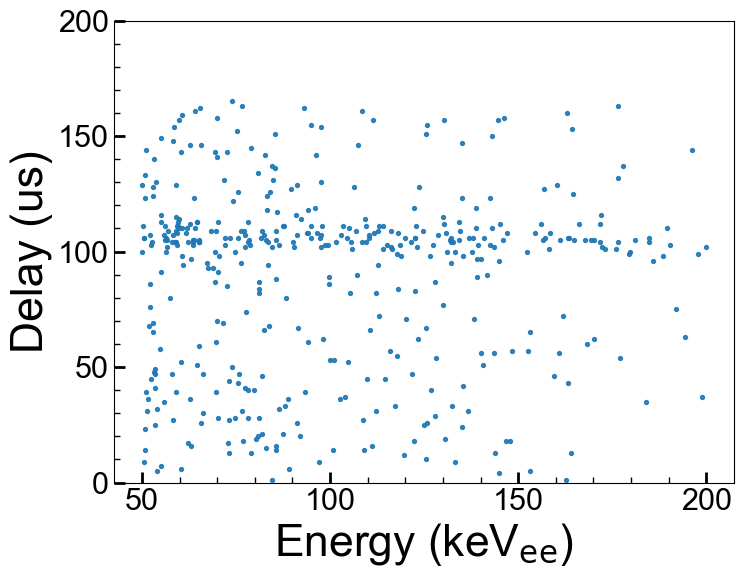

In [16]:
fig, axs = plt.subplots(1,1,figsize=(8,6))
ax1 = axs

ax1.scatter(energies, delay_cfd, marker='o', alpha=0.9, s=8)

ax1.set(xlabel="Energy (keV$_{\mathrm{ee}}$)", ylabel="Delay (us)")
    
#plt.xlim(0, 200)
plt.ylim(0,200)

### Comparing Discriminators

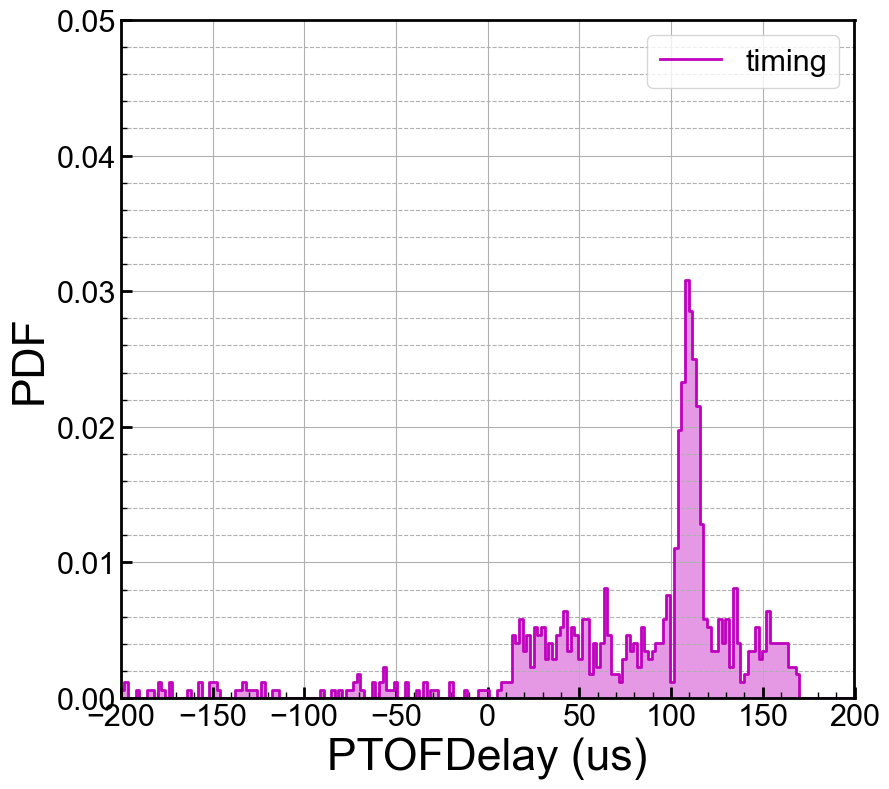

In [17]:
qbins = np.linspace(-200,200,200)
n,nx = np.histogram(delay,bins=qbins)
xcq = (qbins[:-1] + qbins[1:]) / 2

#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

yhist = n/np.sum(n)/np.diff(xcq)[0]


#estring = r'${}\mathrm{{keV}}< E_r \leq {}\mathrm{{keV}}$'.format(Emin,Emax)
#print(estring)
ax1.step(xcq,yhist, where='mid',color='m', linestyle='-', \
            label='timing', linewidth=2)


ymin = 0.0
ymax = 0.05

blue = '#118DFA'
ax1.fill_between(xcq,np.zeros(np.shape(xcq)),yhist,step='mid',facecolor='m',alpha=0.4, \
                 label='')


ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(-200, 200) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'PTOFDelay (us)')
ax1.set_ylabel('PDF')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/MSyieldHist_Figure3a.eps')
#plt.savefig('paper_figures/MSyieldHist_Figure3a.pdf')
plt.show()

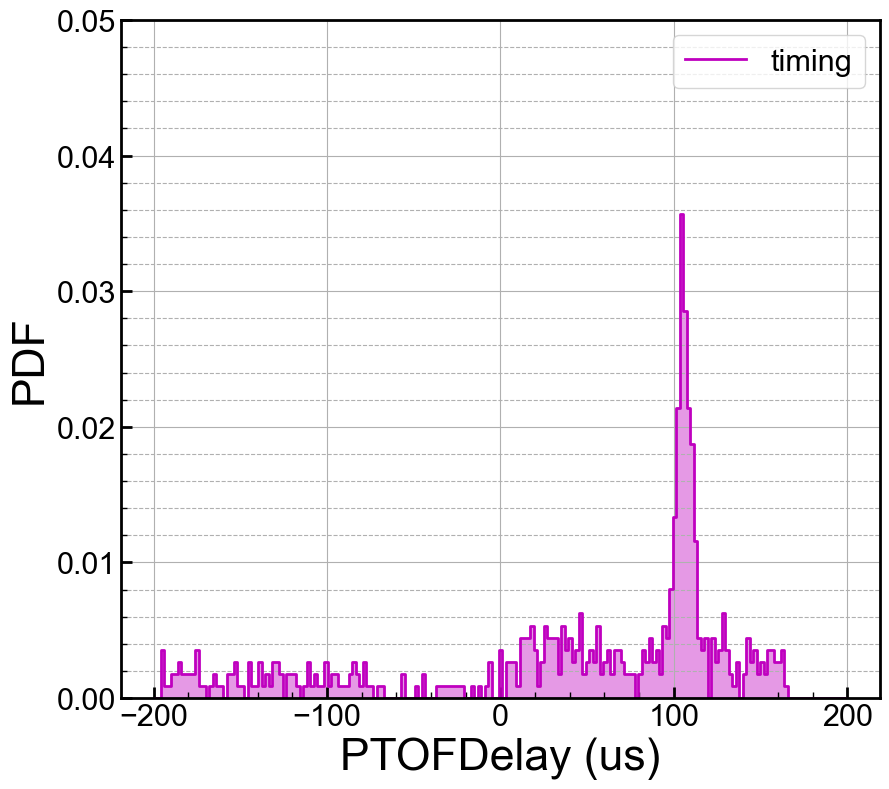

In [18]:
qbins = np.linspace(-200,200,200)
n,nx = np.histogram(delay_cfd,bins=qbins)
xcq = (qbins[:-1] + qbins[1:]) / 2

#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

yhist = n/np.sum(n)/np.diff(xcq)[0]


#estring = r'${}\mathrm{{keV}}< E_r \leq {}\mathrm{{keV}}$'.format(Emin,Emax)
#print(estring)
ax1.step(xcq,yhist, where='mid',color='m', linestyle='-', \
            label='timing', linewidth=2)


ymin = 0.0
ymax = 0.05

blue = '#118DFA'
ax1.fill_between(xcq,np.zeros(np.shape(xcq)),yhist,step='mid',facecolor='m',alpha=0.4, \
                 label='')


ax1.set_yscale('linear')
#ax1.set_yscale('log')
#ax1.set_xlim(-200, 200) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'PTOFDelay (us)')
ax1.set_ylabel('PDF')
#ax1.set_title('CFD')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/MSyieldHist_Figure3a.eps')
#plt.savefig('paper_figures/MSyieldHist_Figure3a.pdf')
plt.show()